In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define transform - same as your CIFAR10 one
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # match CIFAR-10 size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# Use ImageFolder for your dataset
trainset = datasets.ImageFolder(root='cropped/', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root='cropped/', transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class names
classes = trainset.classes
print("Classes:", classes)


Classes: ['Machine', 'Philips', 'Plaster', 'Torx']


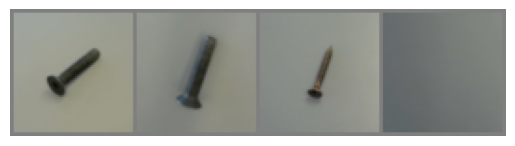

Machine Machine Philips Torx 


In [71]:
# Define unnormalize-and-show function
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (because we normalized to [-1, 1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images from your custom dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images as a grid
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(images))))

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        # We need to calculate the output size after conv layers
        self._to_linear = None  # To store the size before flattening
        
        # Final fully connected layers
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output(self, shape):
        """ 
        Calculate the output size after convolutions and pooling
        For a given input shape.
        """
        x = torch.zeros(*shape)
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv + pool
        return x.view(x.size(0), -1)  # Flatten the output

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Output size: 64x64
        x = self.pool(torch.relu(self.conv2(x)))  # Output size: 32x32
        
        # Calculate the flattened size dynamically
        if self._to_linear is None:
            self._to_linear = self._get_conv_output(x.shape)  # Store the size
            self.fc1 = nn.Linear(self._to_linear.size(1), 128)  # Define fc1 layer
        
        x = torch.relu(self.fc1(x.view(x.size(0), -1)))  # Flatten
        x = self.fc2(x)  # Output layer
        return x


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
net = Net(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        
        # Print output and labels shape to check for mismatches
        print(f"Output shape: {outputs.shape}")
        print(f"Labels shape: {labels.shape}")
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x12544 and 65536x128)

In [ ]:
torch.save(net.state_dict(), 'TV_CNN.pth')